In [1]:
include("models/ppl/main.jl")

In [2]:
using CairoMakie


In [3]:
struct HistoryType
    # policies::Dict{Int, Vector{Policy}}
    mean_rewards::Dict{Int, Vector{Float64}}
    name::String
    info::Dict
end

In [4]:
using JSON3
using Serialization

function load_history_from_json(file_path::String)::HistoryType
    json_data = JSON3.read(file_path)
    mean_rewards = Dict{Int, Vector{Float64}}(
        parse(Int, string(k)) => Float64.(v) for (k, v) in json_data["mean_rewards"]
    )
    name = json_data["info"]["name"]
    # info = Dict(json_data["info"])
    info = Dict(
        string(k) => string(v) for (k, v) in json_data["info"]
    )
    return HistoryType(mean_rewards, name, info)
end


load_history_from_json (generic function with 1 method)

In [5]:
simple = load_history_from_json("json/dirichlet/history/Simple.json")
medium = load_history_from_json("json/dirichlet/history/Medium.json")
full = load_history_from_json("json/dirichlet/history/None.json")
softmax = load_jld("data/mcmc/history/softmax.jld")


PPHistoryRun("softmax", MCMCModel(:softmax, Gen.DynamicChoiceMap(Dict{Any, Any}(), Dict{Any, Any}(:episodes => Gen.DynamicChoiceMap(Dict{Any, Any}(), Dict{Any, Any}(56 => Gen.DynamicChoiceMap(Dict{Any, Any}(), Dict{Any, Any}(:trajectory => Gen.DynamicChoiceMap(Dict{Any, Any}(), Dict{Any, Any}(1 => Gen.DynamicChoiceMap(Dict{Any, Any}(:o2 => NORMAL, :hr => LOW, :bp => HIGH, :glu => LOW), Dict{Any, Any}()))))), 35 => Gen.DynamicChoiceMap(Dict{Any, Any}(), Dict{Any, Any}(:trajectory => Gen.DynamicChoiceMap(Dict{Any, Any}(), Dict{Any, Any}(5 => Gen.DynamicChoiceMap(Dict{Any, Any}(:o2 => NORMAL, :hr => HIGH, :bp => HIGH, :glu => LOW), Dict{Any, Any}()), 4 => Gen.DynamicChoiceMap(Dict{Any, Any}(:o2 => NORMAL, :hr => HIGH, :bp => NORMAL, :glu => LOW), Dict{Any, Any}()), 2 => Gen.DynamicChoiceMap(Dict{Any, Any}(:o2 => NORMAL, :hr => HIGH, :bp => NORMAL, :glu => LOW), Dict{Any, Any}()), 3 => Gen.DynamicChoiceMap(Dict{Any, Any}(:o2 => NORMAL, :hr => HIGH, :bp => NORMAL, :glu => LOW), Dict{Any, An

┌ Warning: Found `resolution` in the theme when creating a `Scene`. The `resolution` keyword for `Scene`s and `Figure`s has been deprecated. Use `Figure(; size = ...` or `Scene(; size = ...)` instead, which better reflects that this is a unitless size and not a pixel resolution. The key could also come from `set_theme!` calls or related theming functions.
└ @ Makie ~/.julia/packages/Makie/Y3ABD/src/scenes.jl:238


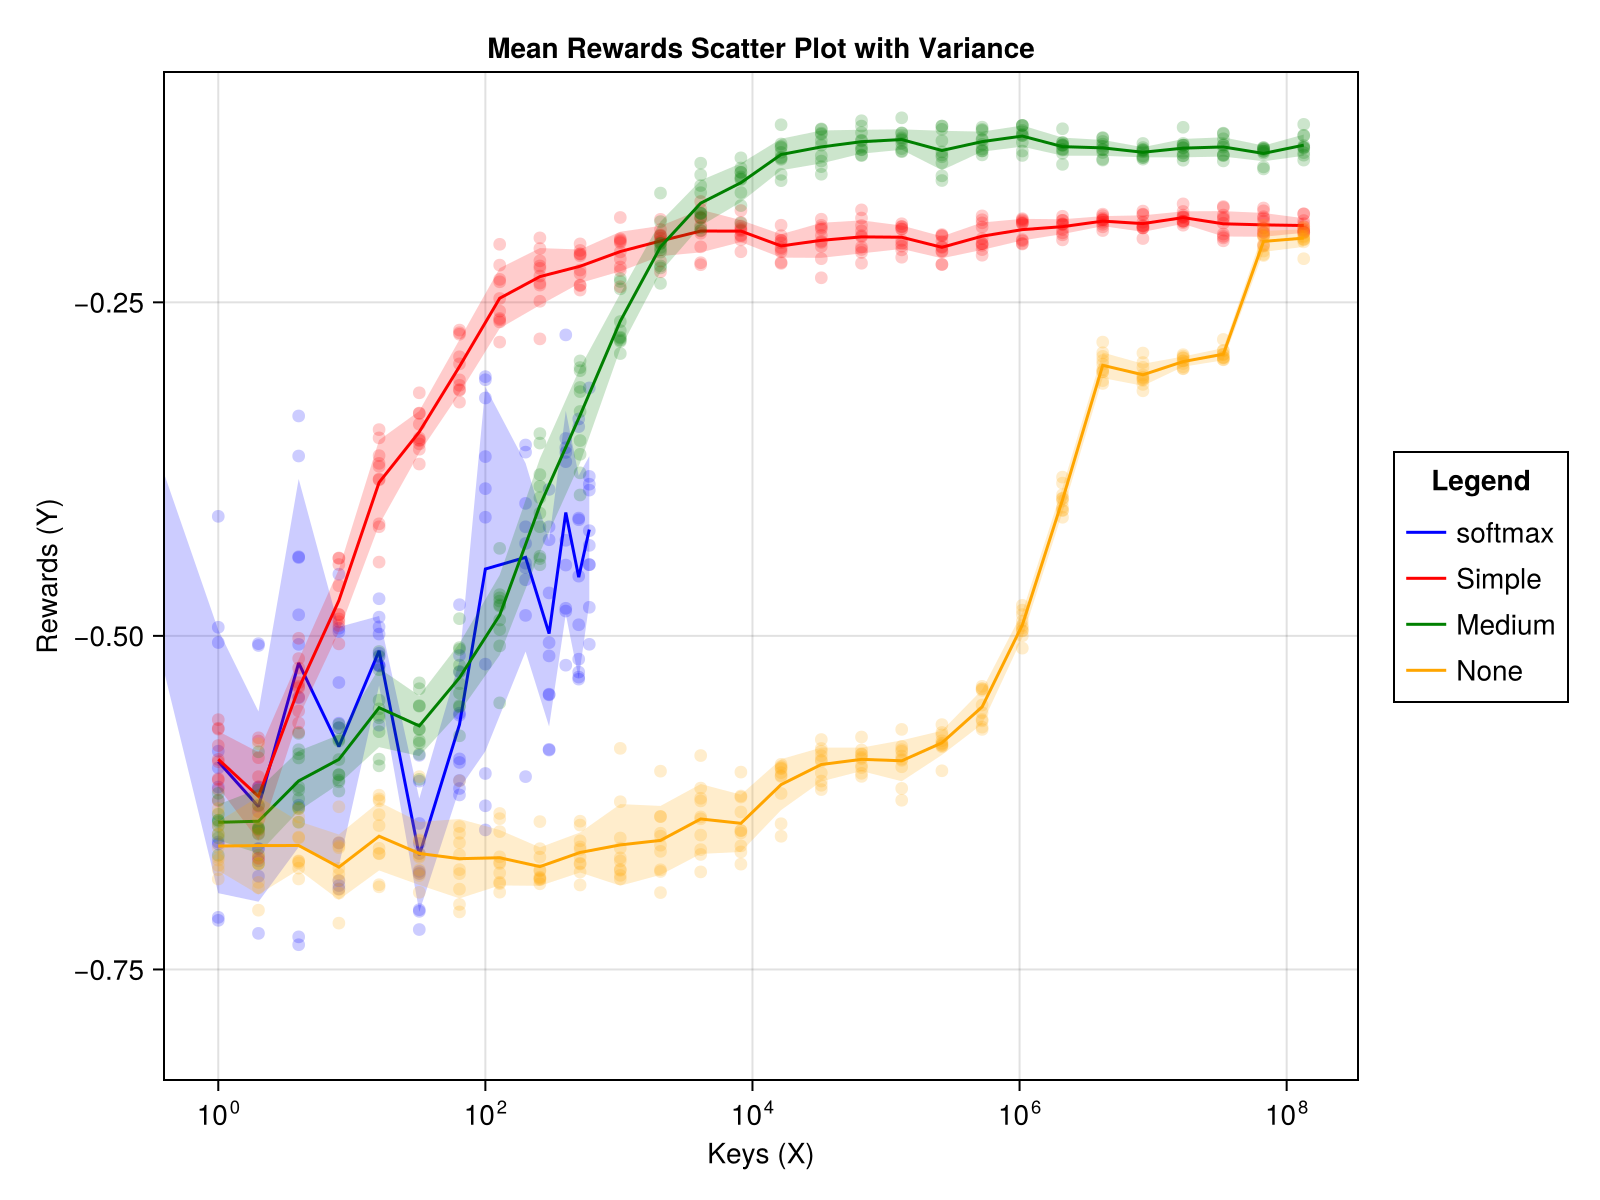

In [6]:
using CairoMakie
using Statistics

# Example: Assuming you have 5 different dictionaries stored in a list
histories = [softmax, simple, medium, full]

# Create a figure
fig = Figure(resolution = (800, 600))
ax = Axis(fig[1, 1], xscale=log10, xlabel = "Keys (X)", ylabel = "Rewards (Y)", title = "Mean Rewards Scatter Plot with Variance")

# Define colors for each dataset
colors = [:blue, :red, :green, :orange, :purple]

# Plot each dataset
for (i, history) in enumerate(histories)
    mean_rewards = history.mean_rewards
    # Prepare data
    x_vals = sort(collect(keys(mean_rewards)))
    y_means = [mean(mean_rewards[x]) for x in x_vals]
    y_stds = [std(mean_rewards[x]) for x in x_vals]

    # Collect all (x, y) pairs for scatter
    scatter_x = []
    scatter_y = []
    for x in x_vals
        ys = mean_rewards[x]
        append!(scatter_x, fill(x, length(ys)))  # Repeat x for each y
        append!(scatter_y, ys)                  # Collect y values
    end

    # Add scatter plot for all points
    scatter!(ax, scatter_x, scatter_y, color = (colors[i], 0.2))

    # Add error band (variance) at the mean points
    band!(ax, x_vals, y_means .- y_stds, y_means .+ y_stds, color = (colors[i], 0.2), )

    # Add line for the mean points
    lines!(ax, x_vals, y_means, color = colors[i], label = history.name)
end
# xlims!(ax, 1, 1300)

# Add a legend
Legend(fig[1, 2], ax, "Legend")



# Display the plot
fig


In [7]:
struct TSType
    # policies::Dict{Int, Vector{Policy}}
    mean_rewards::Dict{Int, Float64}
    name::String
    info::Dict
end

In [ ]:
using JSON3
using Serialization

function load_ts_from_json(file_path::String)::TSType
    json_data = JSON3.read(file_path)
    mean_rewards = Dict{Int, Float64}(
        parse(Int, string(k)) => Float64(v) for (k, v) in json_data["mean_rewards"]
    )
    name = json_data["info"]["name"]
    info = Dict(
        string(k) => string(v) for (k, v) in json_data["info"]
    )
    return TSType(mean_rewards, name, info)
end

load_ts_from_json (generic function with 1 method)

In [9]:
using PyCall
sepsis_gym = pyimport("custom_sepsis")

ts = sepsis_gym.DirThompsonSampling.load_json("json/dirichlet/ts/Simple-0.json")

PyObject <custom_sepsis.models.dirichlet.evaluate.thompson_sampling.DirThompsonSampling object at 0x12ffe3a00>

In [10]:
ts = Dict(
    :Simple => [sepsis_gym.DirThompsonSampling.load_json("json/dirichlet/ts/Simple-$i.json") for i in 0:2],
    :Medium => [sepsis_gym.DirThompsonSampling.load_json("json/dirichlet/ts/Medium-$i.json") for i in 0:2],
    :None => [sepsis_gym.DirThompsonSampling.load_json("json/dirichlet/ts/None-$i.json") for i in 0:2],
    :DQN => []
)

Dict{Symbol, Vector} with 4 entries:
  :None   => PyObject[PyObject <custom_sepsis.models.dirichlet.evaluate.thompso…
  :Medium => PyObject[PyObject <custom_sepsis.models.dirichlet.evaluate.thompso…
  :DQN    => Any[]
  :Simple => PyObject[PyObject <custom_sepsis.models.dirichlet.evaluate.thompso…

In [20]:
ks = sort(collect(keys(ts[:Simple][1].mean_rewards)))
for i in 1:2
    rewards = Dict()
    for k in ks
        training = sepsis_gym.train_dqn(sepsis_gym.true_env, k, k)
        rewards[k] = training.evaluate_policy(100000)
    end
    push!(ts[:DQN], TSType(
        rewards,
        "DQN-$i",
        Dict("name" => "DQN-$i")
    ))
end


In [21]:
length(ts[:DQN])

3

In [22]:
for i in 1:2
    save_ts_to_json(ts[:DQN][i+1], "json/dqn/ts/DQN-$i.json")
end


In [ ]:
using JSON3

function save_ts_to_json(ts_instance::TSType, file_path::String)
    json_data = Dict(
        "mean_rewards" => ts_instance.mean_rewards,
        "name" => ts_instance.name,
        "info" => ts_instance.info
    )
    JSON3.write(file_path, json_data)
end


In [18]:
ts[:DQN][1]

TSType(Dict(200 => -0.61762, 16 => -0.84724, 4700 => -0.41784, 5100 => -0.42472, 1900 => -0.56024, 4100 => -0.44356, 7100 => -0.43272, 700 => -0.65986, 1100 => -0.42709, 5800 => -0.44813…), "DQN-0", Dict{Any, Any}())

In [14]:
save_ts_to_json(ts[:DQN][1], "json/dqn/ts/DQN-0.json")

"json/dqn/ts/DQN-0.json"

In [ ]:
random_mean = mean([sepsis_gym.evaluate_policy(sepsis_gym.random_policy(), 1000) for i in 1:100])

plot_mean_rewards (generic function with 1 method)

┌ Warning: Found `resolution` in the theme when creating a `Scene`. The `resolution` keyword for `Scene`s and `Figure`s has been deprecated. Use `Figure(; size = ...` or `Scene(; size = ...)` instead, which better reflects that this is a unitless size and not a pixel resolution. The key could also come from `set_theme!` calls or related theming functions.
└ @ Makie ~/.julia/packages/Makie/Y3ABD/src/scenes.jl:238


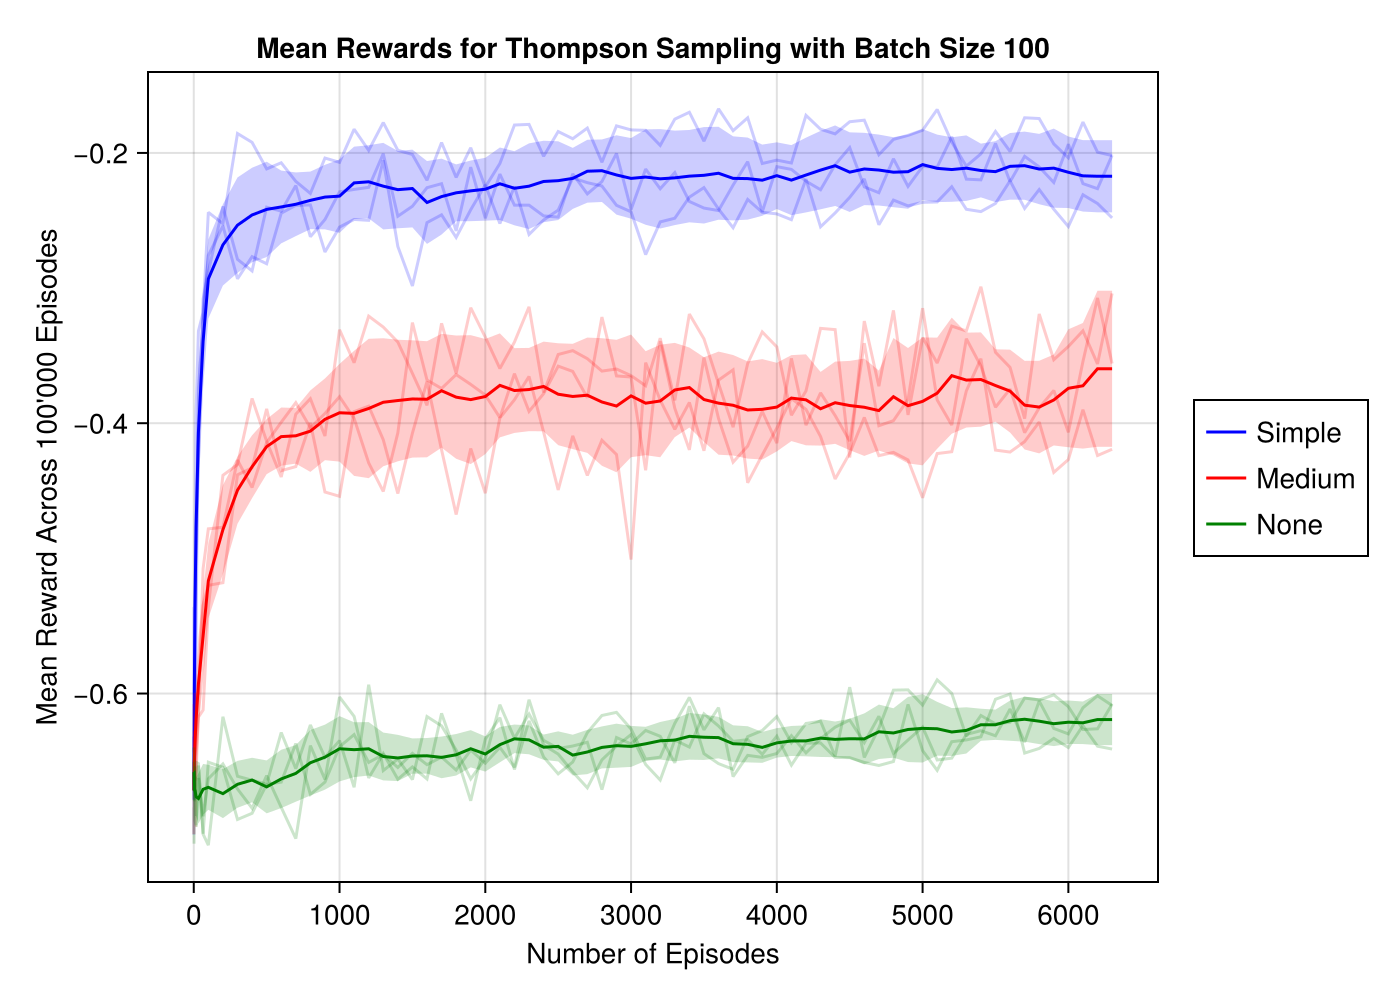

In [ ]:
using Statistics

function moving_average(data, window_size)
    n = length(data)
    cumsum = accumulate(+, vcat(0.0, data))
    smoothed = (cumsum[(window_size+1):end] .- cumsum[1:end-window_size]) ./ window_size
    # Ensure the smoothed array matches the original size
    padding = div(window_size, 2)
    return vcat(fill(data[1], padding), smoothed, fill(data[end], n - length(smoothed) - padding))
end

function plot_mean_rewards(ts)
    fig = Figure(resolution=(700, 500))  
    ax = Axis(fig[1, 1], xlabel = "Number of Episodes", ylabel = "Mean Reward Across 100'000 Episodes", title = "Mean Rewards for Thompson Sampling with Batch Size 100")

    colors = [:blue, :red, :green, :orange, :purple]

    # Modify your plotting loop to smooth the mean curve
    window_size = 5  # Adjust the window size as needed

    for (i, type) in keys(ts)
        all_keys = [sort(collect(keys(model.mean_rewards))) for model in ts[type]]
        min_keys = minimum(length.(all_keys))
        ks = all_keys[1][1:min_keys]
        all_rewards = []
        for model in ts[type]
            rewards = [model.mean_rewards[k] for k in ks]
            push!(all_rewards, rewards)
            lines!(ax, Float64.(ks), Float64.(rewards), color=(colors[i], 0.2))
        end
        mean_rewards = mean(all_rewards)
        smoothed_mean_rewards = moving_average(mean_rewards, window_size)
        lines!(ax, Float64.(ks), Float64.(smoothed_mean_rewards), color=colors[i], linewidth=1.5, label=string(type))

        std_rewards = std(all_rewards)
        smoothed_std_rewards = moving_average(std_rewards, window_size)
        low = smoothed_mean_rewards .- smoothed_std_rewards
        high = smoothed_mean_rewards .+ smoothed_std_rewards
        band!(ax, Float64.(ks), Float64.(low), Float64.(high), color=(colors[i], 0.2))
    end

    lines!(ax, ks, fill(random_mean, length(ks)), color=:black, linestyle=:dash, label="Random Policy")

    Legend(fig[1,2], ax)

    display(fig)
end

In [ ]:
using Statistics

function cumulative_mean_rewards_table(ts, points)
    # Create a dictionary to store results for each model
    results = Dict()

    for (i, type) in keys(ts)
        # Collect cumulative mean rewards for this model type
        model_results = Dict()
        all_keys = [sort(collect(keys(model.mean_rewards))) for model in ts[type]]
        min_keys = minimum(length.(all_keys))
        ks = all_keys[1][1:min_keys]

        for model in ts[type]
            rewards = [model.mean_rewards[k] for k in ks]
            for point in points
                if point <= length(ks)  # Ensure the time point is within range
                    model_results[point] = mean([r[point] for r in [rewards]])
                else
                    model_results[point] = missing
                end
            end
        end

        results[type] = model_results
    end

    # Print the table in a readable format
    println("Cumulative Mean Rewards Table")
    println("================================")
    println("Model Type\t\t" * join(points, "\t"))
    for (type, data) in results
        println(string(type, "\t\t", join(get(data, point, "NaN") for point in points)))
    end
end
